In [1]:
import base64
import io
import os
from typing import Dict

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import requests
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D
from rdkit.Chem import PandasTools
from IPython.display import Image, display, HTML

from process_exps import (
    get_entries,
    get_entry_readings,
    get_entry_gain,
    log_and_norm_reading,
    qc_entry_readings,
    data2df,
)

IPythonConsole.ipython_useSVG = True
# support display images in pandas dataframe
PandasTools.RenderImagesInAllDataFrames(images=True)

In [2]:
# List of experiments ids to be included
included_plateA_exps = [
    "672c3b2dcc59501d47fe96e2",  # 'last_updated': '2024-11-08T13:30:49.533000'
    "67259c4f74ed59c91101ed1e",  # 'last_updated': '2024-11-03T14:03:45.484000'
]
included_plateB_exps = [
    "672c3b2dcc59501d47fe96e4",  # 'last_updated': '2024-11-09T09:33:21.433000'
    "6728dce8808d15cec7ed1d0e",  # 'last_updated': '2024-11-04T10:17:05.801000'
]

included_experiments = included_plateA_exps + included_plateB_exps

# lipids to check
lipid_picks = ["A4B12C10D10", "A4B12C10D11", "A5B12C15D11"]

In [3]:
# Get available entry IDs
entries = get_entries()
# filter entries to include only the ones in the included_experiments list
entries = [entry for entry in entries if entry["id"] in included_experiments]

In [4]:
entries

[{'id': '672c3b2dcc59501d47fe96e4',
  'last_updated': '2024-11-09T09:33:21.433000'},
 {'id': '672c3b2dcc59501d47fe96e2',
  'last_updated': '2024-11-08T13:30:49.533000'},
 {'id': '6728dce8808d15cec7ed1d0e',
  'last_updated': '2024-11-04T10:17:05.801000'},
 {'id': '67259c4f74ed59c91101ed1e',
  'last_updated': '2024-11-03T14:03:45.484000'}]

In [5]:
integrated_data = {}
for entry in entries:
    entry_id = entry["id"]
    print(f"Processing entry {entry_id}...")

    data = get_entry_readings(entry_id)
    normalized_data = log_and_norm_reading(data)
    qc_data = qc_entry_readings(normalized_data)

    integrated_data[entry_id] = qc_data

Processing entry 672c3b2dcc59501d47fe96e4...
Processing entry 672c3b2dcc59501d47fe96e2...
Processing entry 6728dce8808d15cec7ed1d0e...
Processing entry 67259c4f74ed59c91101ed1e...


In [6]:
df = data2df(integrated_data)
df["plate"] = df[f"reading.{included_plateB_exps[0]}"].apply(lambda x: "A" if np.isnan(x) else "B")

# 1. Top 10 of max readings among all experiments

In [7]:
df_sorted_raw_globally = df.sort_values("max", ascending=False)
lipid_ids = df_sorted_raw_globally.index
for i, lipid in enumerate(lipid_picks):
    if lipid in lipid_ids:
        # get its position in the sorted dataframe
        lipid_index = lipid_ids.get_loc(lipid)
        print(f"Lipid{i+1}({lipid}) is top {lipid_index+1} in the sorted dataframe")


top10_raw_globally = df_sorted_raw_globally.head(10)

Lipid1(A4B12C10D10) is top 23 in the sorted dataframe
Lipid2(A4B12C10D11) is top 106 in the sorted dataframe
Lipid3(A5B12C15D11) is top 19 in the sorted dataframe


# 2. Top 5 of max readings in plate A and top 5 in plate B

In [8]:
df_sorted_raw_plateA = df[df["plate"] == "A"].sort_values("max", ascending=False)
lipid_ids = df_sorted_raw_plateA.index
for i, lipid in enumerate(lipid_picks):
    if lipid in lipid_ids:
        # get its position in the sorted dataframe
        lipid_index = lipid_ids.get_loc(lipid)
        print(f"Lipid{i+1}({lipid}) is top {lipid_index+1} in the sorted dataframe A")

top5_raw_plateA = df_sorted_raw_plateA.head(5)

df_sorted_raw_plateB = df[df["plate"] == "B"].sort_values("max", ascending=False)
lipid_ids = df_sorted_raw_plateB.index
for i, lipid in enumerate(lipid_picks):
    if lipid in lipid_ids:
        # get its position in the sorted dataframe
        lipid_index = lipid_ids.get_loc(lipid)
        print(f"Lipid{i+1}({lipid}) is top {lipid_index+1} in the sorted dataframe B")

top5_raw_plateB = df_sorted_raw_plateB.head(5)

top10_raw_separately = pd.concat([top5_raw_plateA, top5_raw_plateB])

Lipid1(A4B12C10D10) is top 10 in the sorted dataframe A
Lipid2(A4B12C10D11) is top 50 in the sorted dataframe A
Lipid3(A5B12C15D11) is top 7 in the sorted dataframe A


# 3. Top 10 of max readings among all experiments, with calibrated controls

In [9]:
integrated_data = {}
for entry in entries:
    entry_id = entry["id"]
    print(f"Processing entry {entry_id}...")

    gain_values = get_entry_gain(entry_id)
    print(f"Gain values: {gain_values}")

    data = get_entry_readings(entry_id)
    normalized_data = log_and_norm_reading(data, gain_values)
    qc_data = qc_entry_readings(normalized_data)

    integrated_data[entry_id] = qc_data

Processing entry 672c3b2dcc59501d47fe96e4...
Gain values: {'0': 175, '1': 174, '2': 174, '3': 173}
Inferred log control reading from gain 175: 3.66
Inferred log control reading from gain 174: 3.60
Inferred log control reading from gain 174: 3.60
Inferred log control reading from gain 173: 3.54
Processing entry 672c3b2dcc59501d47fe96e2...
Gain values: {'0': 154, '1': 154, '2': 152, '3': 152}


Inferred log control reading from gain 154: 2.42
Inferred log control reading from gain 154: 2.42
Inferred log control reading from gain 152: 2.31
Inferred log control reading from gain 152: 2.31
Processing entry 6728dce8808d15cec7ed1d0e...
Gain values: {'0': 197, '1': 199, '2': 204, '3': 205}
Inferred log control reading from gain 197: 4.96
Inferred log control reading from gain 199: 5.08
Inferred log control reading from gain 204: 5.37
Inferred log control reading from gain 205: 5.43
Processing entry 67259c4f74ed59c91101ed1e...
Gain values: {'0': 163, '1': 163, '2': 154, '3': 155}
Inferred log control reading from gain 163: 2.95
Inferred log control reading from gain 163: 2.95
Inferred log control reading from gain 154: 2.42
Inferred log control reading from gain 155: 2.48


In [10]:
df = data2df(integrated_data)
df["plate"] = df[f"reading.{included_plateB_exps[0]}"].apply(lambda x: "A" if np.isnan(x) else "B")

In [11]:
df_sorted_calib_globally = df.sort_values("max", ascending=False)
lipid_ids = df_sorted_calib_globally.index
for i, lipid in enumerate(lipid_picks):
    if lipid in lipid_ids:
        # get its position in the sorted dataframe
        lipid_index = lipid_ids.get_loc(lipid)
        print(f"Lipid{i+1}({lipid}) is top {lipid_index+1} in the sorted dataframe")


top10_calib_globally = df_sorted_calib_globally.head(10)

Lipid1(A4B12C10D10) is top 6 in the sorted dataframe
Lipid2(A4B12C10D11) is top 64 in the sorted dataframe
Lipid3(A5B12C15D11) is top 2 in the sorted dataframe


,smiles,mol_img,amine,isocyanide,aldehyde,carboxylic_acid,max,mean,std,reading.672c3b2dcc59501d47fe96e4,reading.6728dce8808d15cec7ed1d0e,reading.672c3b2dcc59501d47fe96e2,reading.67259c4f74ed59c91101ed1e,plate
A8B12C15D9,CCCCCCCC/C=C\CCCCCCCC(C(=O)NC12C[C@H]3C[C@@H](...,,A8,B12,C15,D9,17.608274,13.210619,6.219224,NaN,NaN,17.608274,8.812964,A
A5B12C15D11,CCCCCCCC/C=C\CCCCCCCC(C(=O)NC12C[C@H]3C[C@@H](...,,A5,B12,C15,D11,17.426002,15.400945,2.863863,NaN,NaN,13.375888,17.426002,A
A1B12C9D10,CCCCCCC(CCCC)C(=O)OCCCCCC(C(=O)NC12C[C@H]3C[C@...,,A1,B12,C9,D10,17.287622,16.427183,1.216844,NaN,NaN,17.287622,15.566745,A
A4B12C15D10,CCCCCCCC/C=C\CCCCCCCC(C(=O)NC12C[C@H]3C[C@@H](...,,A4,B12,C15,D10,17.010321,16.266762,1.051551,NaN,NaN,17.010321,15.523203,A
A8B12C16D10,CCCCC/C=C\C/C=C\CCCCCCCC(C(=O)NC12C[C@H]3C[C@@...,,A8,B12,C16,D10,16.953326,11.271027,8.035984,NaN,NaN,16.953326,5.588729,A
A4B12C10D10,CCCCCCCCC(CCCCCC)C(=O)OCCCCCC(C(=O)NC12C[C@H]3...,,A4,B12,C10,D10,16.918137,13.203733,5.252961,NaN,NaN,9.489329,16.918137,A
A8B12C13D10,CCCCCCCCCCCCCCCCC(C(=O)NC12C[C@H]3C[C@@H](C1)C...,,A8,B12,C13,D10,16.883655,11.388927,7.770718,NaN,NaN,16.883655,5.8942,A
A8B7C9D9,CCCCCCC(CCCC)C(=O)OCCCCCC(C(=O)NC1CCCCC1)N(CCN...,,A8,B7,C9,D9,16.851962,11.507412,7.558334,NaN,NaN,16.851962,6.162863,A
A8B12C9D10,CCCCCCC(CCCC)C(=O)OCCCCCC(C(=O)NC12C[C@H]3C[C@...,,A8,B12,C9,D10,16.458393,13.788205,3.776216,NaN,NaN,16.458393,11.118017,A
A5B10C15D23,CCCCCCCC/C=C\CCCCCCCC(C(=O)NCCCC)N(CCCN(C)C)C(...,,A5,B10,C15,D23,16.364209,14.794678,2.219651,16.364209,13.225148,NaN,NaN,B

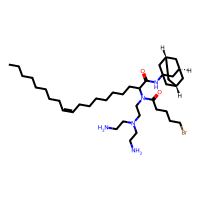
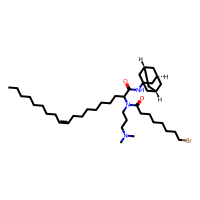
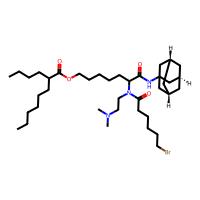
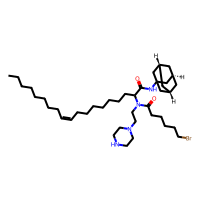
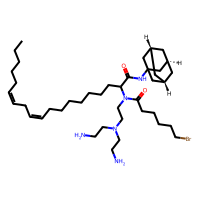
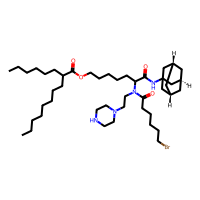
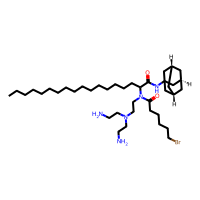
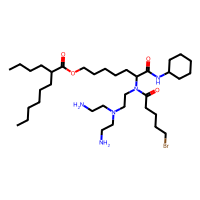
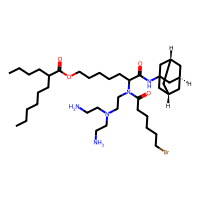
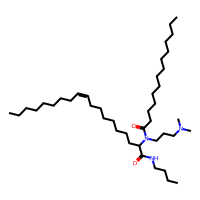

In [12]:
top10_calib_globally

In [13]:
top10_calib_globally.to_csv("top10_for_invivo.csv")